# 1. README

1. run line-by-line by highlighting each line and using Control+Shift+Enter to see the changes after each line

2. Please note that the loading of model is done in the notebook as well.

# 2. MOUNTING DRIVE

In [162]:
# run this once for google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. IMPORTING LIBRARIES AND DATASET

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import (
    LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor,
    RANSACRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
import xgboost
from lightgbm import LGBMRegressor


In [164]:
# Initialise dataframe
df2 = pd.read_csv('/content/drive/MyDrive/catA_train.csv')

# 4. DATA CLEANING AND PREPARATION

## 4.1 GET MORE INFO ABOUT DATAFRAME

In [165]:
print(df2.info())
# find no. of rows and columns
print(df2.shape)
# find headers of columns
print(df2.columns)
# find no. of missing values in each column
df2.isna().sum()
# show count, mean, std, and quantile information for each numerical column
df2.describe()
# look at first 5 rows
pd.set_option('display.max_columns', None)
df2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29182 entries, 0 to 29181
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   LATITUDE                             29062 non-null  float64
 1   LONGITUDE                            29062 non-null  float64
 2   AccountID                            29182 non-null  object 
 3   Company                              29182 non-null  object 
 4   SIC Code                             29182 non-null  float64
 5   Industry                             29182 non-null  object 
 6   8-Digit SIC Code                     29182 non-null  float64
 7   8-Digit SIC Description              29182 non-null  object 
 8   Year Found                           28748 non-null  float64
 9   Entity Type                          29182 non-null  object 
 10  Parent Company                       28668 non-null  object 
 11  Parent Country              

,LATITUDE,LONGITUDE,AccountID,Company,SIC Code,Industry,8-Digit SIC Code,8-Digit SIC Description,Year Found,Entity Type,Parent Company,Parent Country,Ownership Type,Company Description,Square Footage,Company Status (Active/Inactive),Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Fiscal Year End,Global Ultimate Company,Global Ultimate Country,Domestic Ultimate Company,Is Domestic Ultimate,Is Global Ultimate
0,1.285495,103.843852,LAKB2BID4559214,FRANK CONSULTING SERVICES PRIVATE LIMITED,7361.0,Employment Agencies,73610000.0,Employment agencies,2020.0,Subsidiary,FRANK RECRUITMENT GROUP PRIVATE LTD.,Singapore,Private,Frank Consulting Services Private Limited is p...,NaN,Active,15.0,25.0,NaN,2.209224e+06,4.637871e+06,NaN,NaN,FINDERS HOLDCO LIMITED,United Kingdom,FRANK RECRUITMENT GROUP PRIVATE LTD.,0.0,0.0
1,1.291294,103.827476,LAKB2BID7610849,NEW DESERT ORCHID SHIPPING PTE. LTD.,4449.0,"Water Transportation of Freight, Not Elsewhere...",44490000.0,Water transportation of freight,2015.0,Subsidiary,FORTITUDE SHIPPING PTE. LTD.,Singapore,Private,New Desert Orchid Shipping Pte. Ltd. is primar...,NaN,Active,39.0,100.0,100.0,7.093536e+09,7.093536e+09,NaN,NaN,PETREDEC PTE. LIMITED,Singapore,NaN,0.0,0.0
2,1.300144,103.857517,LAKB2BID5461679,2MBAO BIOCELLBANK PTE. LTD.,6719.0,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.0,"Holding companies, nec",1993.0,Subsidiary,MADISON LIGHTERS AND WATCHES CO LTD,Hong Kong SAR,Private,2Mbao Biocellbank Pte. Ltd. is primarily engag...,NaN,Active,4.0,4.0,4.0,1.026308e+06,1.026308e+06,NaN,NaN,MADISON LIGHTERS AND WATCHES CO LTD,Hong Kong SAR,2MBAO BIOCELLBANK PTE. LTD.,1.0,0.0
3,1.300785,103.791263,LAKB2BID5088529,NEWBLOOM PTE. LTD.,6719.0,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.0,"Holding companies, nec",2006.0,Subsidiary,WILMAR INTERNATIONAL LIMITED,Singapore,Private,Newbloom Pte. Ltd. is primarily engaged in hol...,NaN,Active,10.0,100.0,100.0,7.339898e+10,7.339898e+10,NaN,NaN,WILMAR INTERNATIONAL LIMITED,Singapore,WILMAR INTERNATIONAL LIMITED,0.0,0.0
4,1.298759,103.859430,LAKB2BID1268831,ASIA GREEN CAPITAL PTE. LTD.,6719.0,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.0,"Holding companies, nec",2006.0,Parent,ASIA GREEN CAPITAL PTE. LTD.,Singapore,Private,Asia Green Capital Pte. Ltd. is primarily enga...,NaN,Active,NaN,4.0,4.0,4.322130e+05,4.322130e+05,Exports,NaN,ASIA GREEN CAPITAL PTE. LTD.,Singapore,ASIA GREEN CAPITAL PTE. LTD.,1.0,1.0


##4.2  TRIM DOWN ROWS & COLUMNS


In [166]:
# remove rows without either lat or long coordinates
df2 = df2.dropna(subset=["LATITUDE", "LONGITUDE"])
# remove rows where the Company Status is 'Inactive'
df2 = df2[df2['Company Status (Active/Inactive)'] == 'Active']
# new column to indicate whether import/export status is missing
df2['Import/Export Status_Missing'] = df2['Import/Export Status'].isna()
# drop unnecessary columns, will drop more columns during EDA if weak/no correlation is found, reassign to df3
df3 = df2.drop(columns=[col for col in ["Industry", "8-Digit SIC Code", "8-Digit SIC Description","Company Status (Active/Inactive)", "AccountID", "Square Footage", "Company", "Company Description", "Domestic Ultimate Company", "Fiscal Year End", "Parent Company", "Parent Country", "Global Ultimate Company", "Global Ultimate Country"] if col in df2.columns], errors='ignore')

## 4.3 FILL IN NULL VALUES



We decided to use KNN imputer for filling in missing values as the no. of missing values were too large to ignore. We chose KNN imputer over other methods like interpolation or mean/median imputation as we believe it was most suitable for this dataset due to:

1. Large dataset for more accurate KNN imputations

2. More robust and reduces the impact of outliers as it considers the neighbourhood of the sample

3. Missing-at-random values
4. Missing values were in numerical features


In [167]:
# overview of null values
df3.isna().sum()
# Use KNN Imputer for filling missing values, as some columns (Employees (Single Site)) have large no. of missing values
imputer = KNNImputer(n_neighbors=5)
# Select columns for imputation
columns_to_impute = ['Employees (Single Site)', 'Year Found', 'Employees (Domestic Ultimate Total)','Employees (Global Ultimate Total)'   ]
# Perform imputation
df3[columns_to_impute] = imputer.fit_transform(df3[columns_to_impute])
df3["Year Found"] = df3["Year Found"].astype('int')

## 4.4 REDUCING CURSE OF DIMENSIONALITY

We first categorise companies according to the first digit of the SIC Code, which represents the company's economic division. We then set a threshold for low-frequency SIC codes which will be labelled "Others" to reduce the effects of the curse of dimensionality.

In [168]:
# Categorise companies based on the first digit of SIC Code, which represents the company's economic division

#Extract first digit of SIC Code
df3['SIC Code'] = df3['SIC Code'].astype(int)
df3['SIC Code'] //=1000
df3['SIC Code'] = df3['SIC Code'].astype(str)

# Set a threshold for low-frequency SIC Codes
threshold = 1000

# Identify SIC Codes with frequency below the threshold
sic_code_frequency = df3['SIC Code'].value_counts()
low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index.tolist()

# Replace these low-frequency SIC Codes with a common label "Others"
df3['SIC Code'] = df3['SIC Code'].replace(low_frequency_sic_codes, 'Others')

sic_code_frequency1 = df3['SIC Code'].value_counts()

# Display the updated DataFrame
print(sic_code_frequency1)

6         10322
5          5720
8          3916
7          3585
4          2277
Others     1748
3          1494
Name: SIC Code, dtype: int64


# 5. EDA

## 5.1 TARGET VARIABLE ANALYSIS (SALES)

We used histograms for data visualization as histograms provide a clear visual representation of the sales data's distribution, making it easier to identify trends and potential outliers. Additionally, boxplots were also utilized as they offer a clear visual representation of spread and dispersion, allowing for the identification of variations and trends.

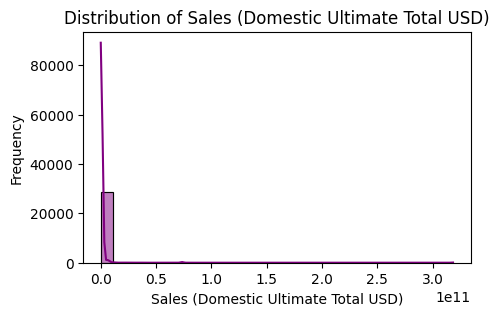

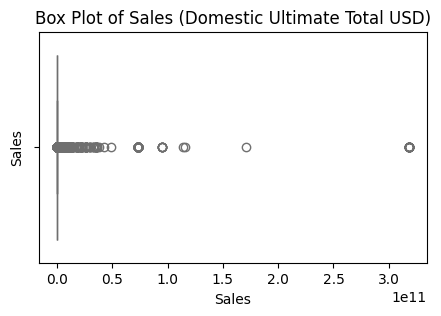

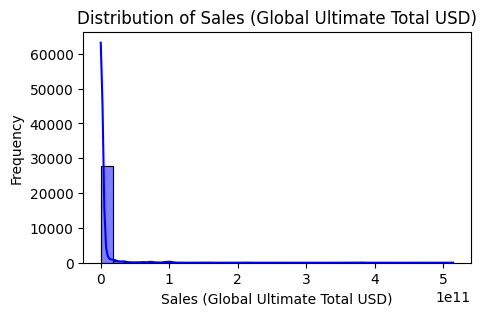

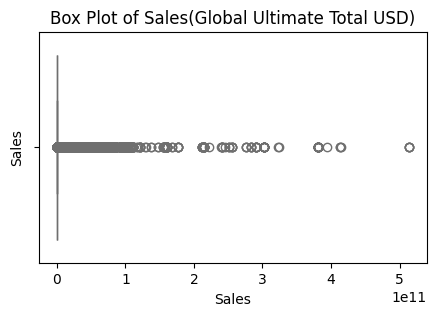

In [170]:
# Histogram: Sales (Domestic Ultimate Total USD)

plt.figure(figsize=(5, 3))
sns.histplot(df3['Sales (Domestic Ultimate Total USD)'], bins=30, kde=True, color='purple')
plt.title('Distribution of Sales (Domestic Ultimate Total USD)')
plt.xlabel('Sales (Domestic Ultimate Total USD)')
plt.ylabel('Frequency')
plt.show()

# Boxplot: Sales (Domestic Ultimate Total USD)
plt.figure(figsize=(5, 3))
ax = sns.boxplot(x=df3['Sales (Domestic Ultimate Total USD)'], color='skyblue')
plt.title('Box Plot of Sales (Domestic Ultimate Total USD)')
plt.xlabel('Sales')
plt.ylabel('Sales')
plt.show()

# Histogram: Sales (Global Ultimate Total USD)
plt.figure(figsize=(5, 3))
sns.histplot(df3['Sales (Global Ultimate Total USD)'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sales (Global Ultimate Total USD)')
plt.xlabel('Sales (Global Ultimate Total USD)')
plt.ylabel('Frequency')
plt.show()


# Boxplot: Sales (Global Ultimate Total USD)
plt.figure(figsize=(5, 3))
sns.boxplot(x=df3['Sales (Global Ultimate Total USD)'], color='skyblue')
plt.title('Box Plot of Sales(Global Ultimate Total USD)')
plt.xlabel('Sales')
plt.ylabel('Sales')
plt.show()





Our histograms on both Domestic and Global sales are highly right-skewed and span many orders of magnitude. Hence, we decided to perform a log transformation on both sales columns to improve subsequent statistical tests and improve model performance. After doing so, the sales distribution becomes closer to normal distribution.

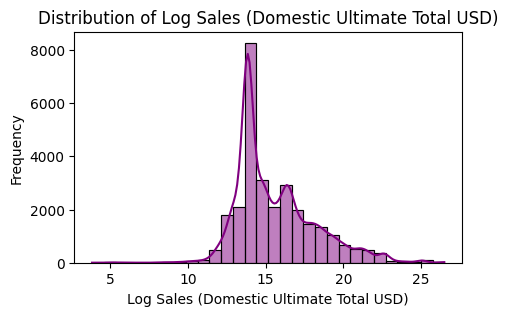

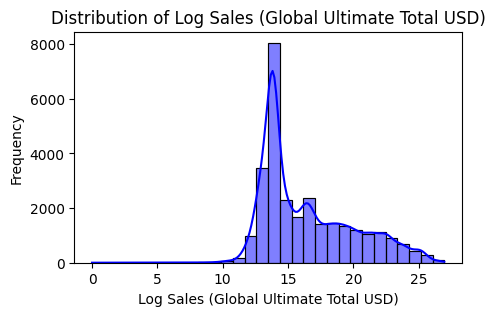

In [172]:
df3 = df3[(df3['Sales (Domestic Ultimate Total USD)'] >= 0)]
df3['Log Sales (Domestic Ultimate Total USD)'] = np.log(df3['Sales (Domestic Ultimate Total USD)'])

df3 = df3[(df3['Sales (Global Ultimate Total USD)'] >= 0)]
df3['Log Sales (Global Ultimate Total USD)'] = np.log(df3['Sales (Global Ultimate Total USD)'])

# Histogram: Sales (Log Domestic Ultimate Total USD)

plt.figure(figsize=(5, 3))
sns.histplot(df3['Log Sales (Domestic Ultimate Total USD)'], bins=30, kde=True, color='purple')
plt.title('Distribution of Log Sales (Domestic Ultimate Total USD)')
plt.xlabel('Log Sales (Domestic Ultimate Total USD)')
plt.ylabel('Frequency')
plt.show()

# Histogram: Sales (Log Global Ultimate Total USD)
plt.figure(figsize=(5, 3))
sns.histplot(df3['Log Sales (Global Ultimate Total USD)'], bins=30, kde=True, color='blue')
plt.title('Distribution of Log Sales (Global Ultimate Total USD)')
plt.xlabel('Log Sales (Global Ultimate Total USD)')
plt.ylabel('Frequency')
plt.show()

# Sales distribution becomes closer to normal distribution

## 5.2 QUANTITATIVE FEATURES ANALYSIS

### 5.2.1 CORRELATION MATRIX

A correlation matrix is performed to help us better understand the relationship between pairs of variables. When doing so, we are then able to  identify highly correlated variables and process our data accordingly.
We created a heatmap for a visual representation of our correlation matrix. This provides an intuitive way to explore relationships between variables, as strength of correlations are color-coded, making it easy to spot patterns.

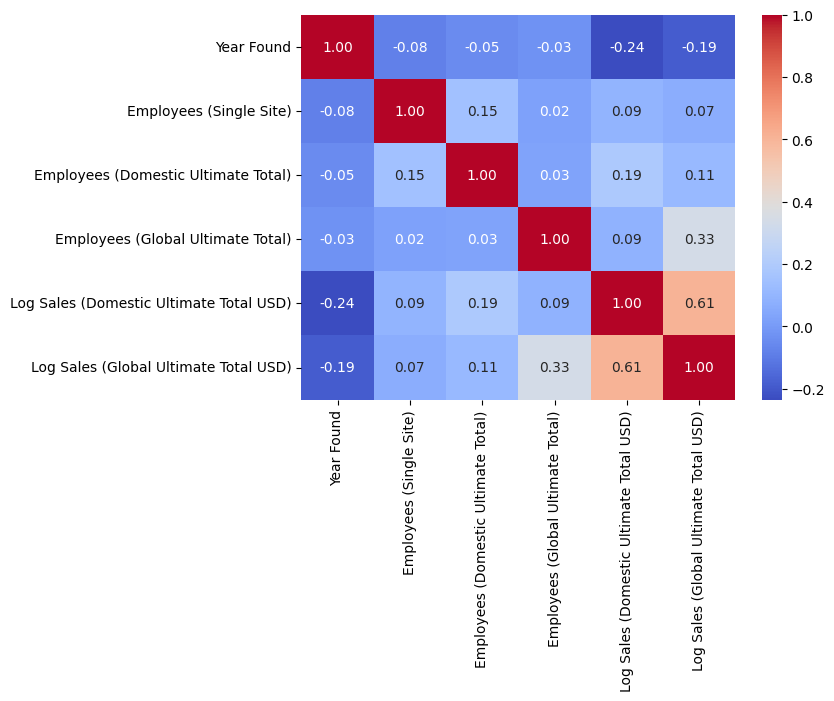

In [173]:
# Correlation matrix with quantitative variables
quantvar = df3[["Year Found", "Employees (Single Site)", "Employees (Domestic Ultimate Total)", "Employees (Global Ultimate Total)", "Log Sales (Domestic Ultimate Total USD)", "Log Sales (Global Ultimate Total USD)"]]
corr = quantvar.corr()

# Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

ANALYSIS OF HEAT MAP:

One of the highest correlation value between 2 differing variables is found to be 0.33 which occured between Employees (Global Ultimate Total) and Log Sales (Global Ultimate Total USD). As the number of employees (Global Ultimate Total) increases, there is a tendency for log-transformed sales (Global Ultimate Total USD) to also increase. A growing workforce may enable a company to establish a more significant presence in the market. With more employees, a company can invest in marketing, sales efforts, and customer service, potentially expanding its reach to a larger audience and attracting more customers.
Further, more employees may mean more diverse skills and expertise, fostering creativity and the development of new products or services. All of these could have led to the higher log sales observed.

Another interesting insight gained is that there is a negative correlation between Year Found and Log Sales (both Global and Domestic). This means that the more recent the company was founded, the log-transformed sales tend to decrease slightly. Comparing to younger companies, companies with longer histories could have more time to establish themselves, build a customer base, and expand their business operations, thus it would be reasonable for them to expect higher sales.

### 5.2.2 GEOSPATIAL ANALYSIS

We use k-means clustering to find association of geographical location to sales.

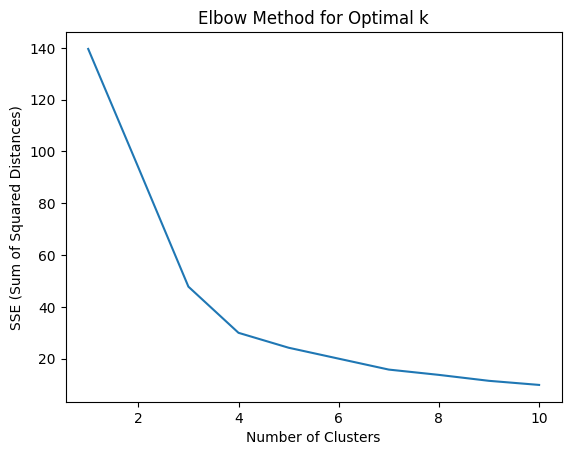

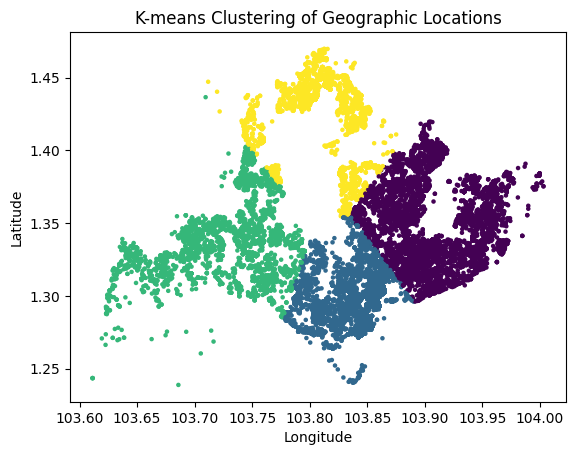

In [174]:
#Finding the best k
X = df3[['LATITUDE', 'LONGITUDE']]

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto').fit(X)
    sse[k] = kmeans.inertia_

# Plotting SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.show()

#Choose k = 4 using Elbow Method

# Choosing the number of clusters (k)
kmeans = KMeans(n_clusters=4, n_init = 'auto')
kmeans.fit(X)

# Getting cluster assignments
df3['Cluster'] = kmeans.labels_

# Plotting the clusters
plt.scatter(df3['LONGITUDE'], df3['LATITUDE'], c=df3['Cluster'], cmap='viridis', s = 5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Geographic Locations')
plt.show()


We plot side-by-side boxplots of log sales in each cluster.

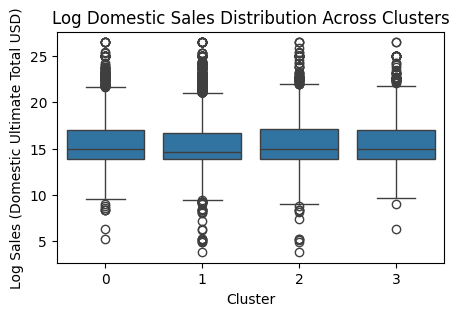

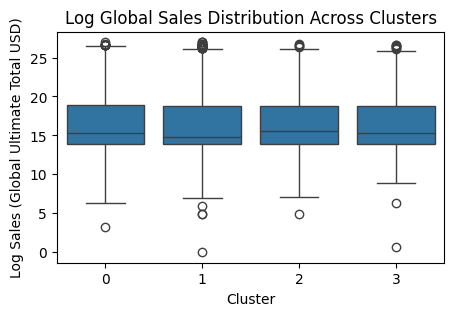

In [175]:
#Domestic Sales
plt.figure(figsize=(5, 3))
boxes=sns.boxplot(x='Cluster', y='Log Sales (Domestic Ultimate Total USD)', data=df3)
plt.title('Log Domestic Sales Distribution Across Clusters')
plt.show()

#Global Sales
plt.figure(figsize=(5,3))
sns.boxplot(x='Cluster', y='Log Sales (Global Ultimate Total USD)', data=df3)
plt.title('Log Global Sales Distribution Across Clusters')
plt.show()


Since the all the clusters have similar domestic and global sales quartiles, it seems that location has little influence on sales for now.

### 5.2.3 ANALYSIS OF YEAR FOUNDED

We first plot a histogram to learn more about the distribution of 'Year Found'.

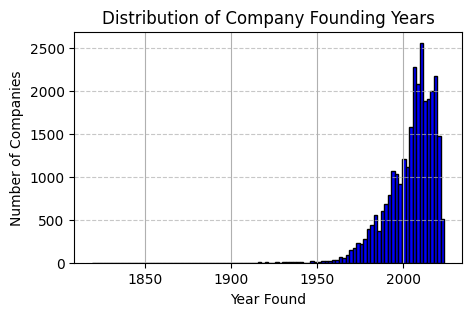

Median: 2008
Mode: 2011
Number of companies founded in 2011: 1323


In [176]:
plt.figure(figsize=(5, 3))
df3['Year Found'].hist(bins=100, color='blue', edgecolor='black', range = (1819, 2024))
plt.title('Distribution of Company Founding Years')
plt.xlabel('Year Found')
plt.ylabel('Number of Companies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# get median
median = int(df3['Year Found'].median())
# get mode
mode = int(df3['Year Found'].mode()[0])
count = df3['Year Found'].value_counts()[mode]
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Number of companies founded in {mode}: {count}")

We then plot a scatterplot to visualise the relationship between 'Year Found' and 'Log Sales (Domestic Ultimate Total USD)'.

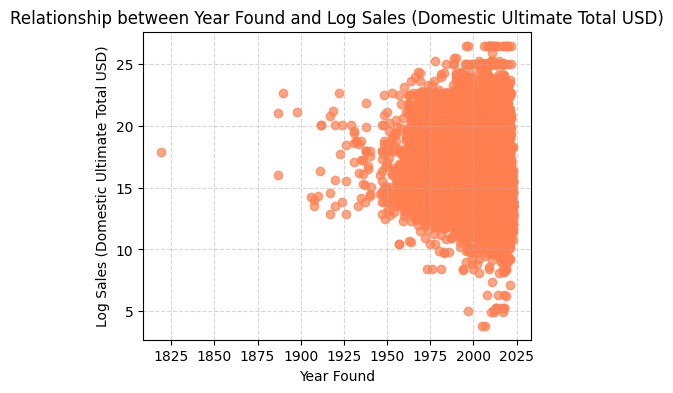

In [180]:
plt.figure(figsize=(5, 4))
plt.scatter(df3['Year Found'], df3['Log Sales (Domestic Ultimate Total USD)'], color='coral', alpha=0.7)
plt.title('Relationship between Year Found and Log Sales (Domestic Ultimate Total USD)')
plt.xlabel('Year Found')
plt.ylabel('Log Sales (Domestic Ultimate Total USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

One key observation we had: the more recently the company was founded, the greater the variance in sales.

More recently founded companies may undergo periods of experimentation and adjustment - such as investing in infrastructure, marketing, and other growth initiatives  , leading to fluctuations in sales until a more stable business model is established. This explains the greater variance in their sales.


### 5.2.4 ANALYSIS OF EMPLOYEES

Again, we then plot scatterplots to visualise the relationship between 'Employees (Single Site)'/'Employees (Domestic Ultimate Total)'/'Employees (Global Ultimate Total)' and 'Log Sales (Domestic Ultimate Total USD)'.

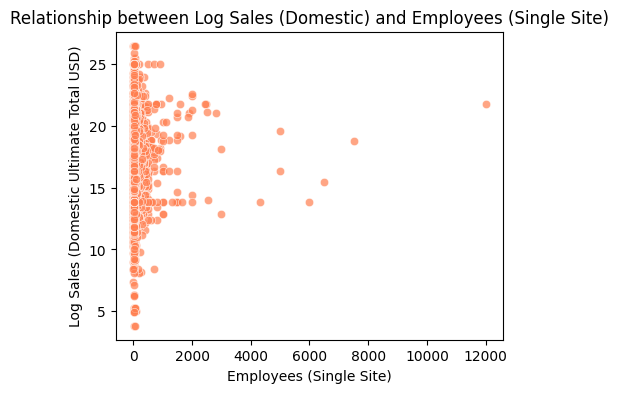

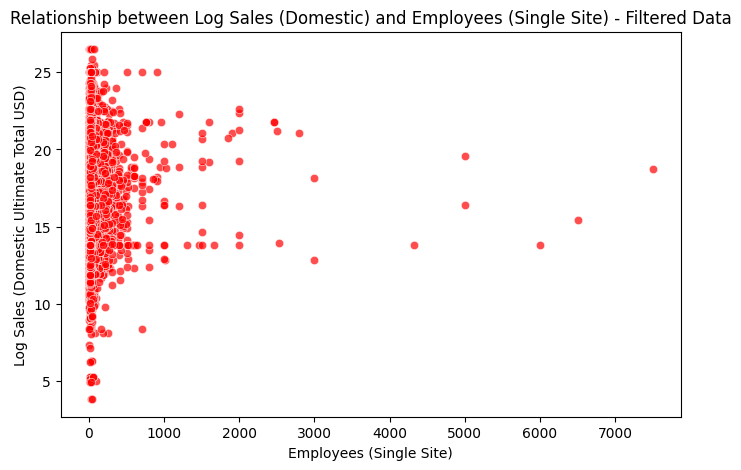

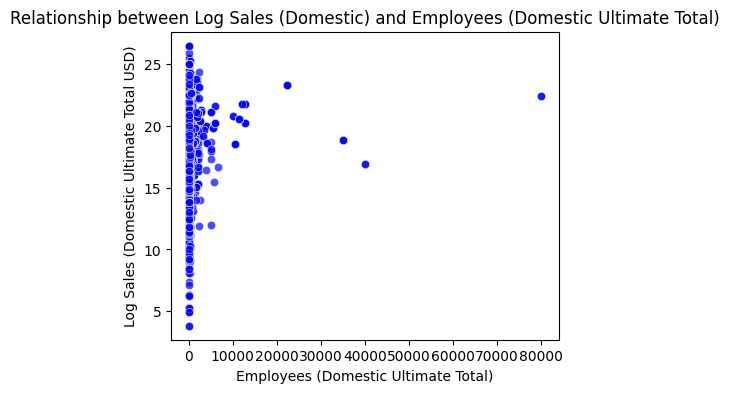

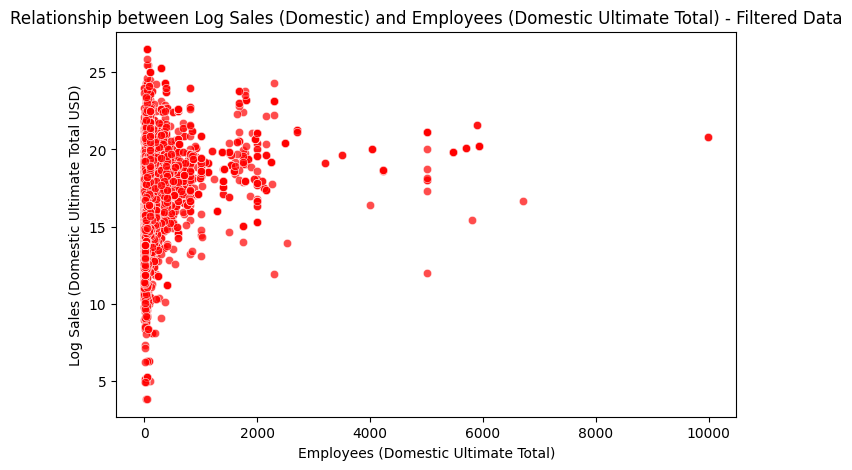

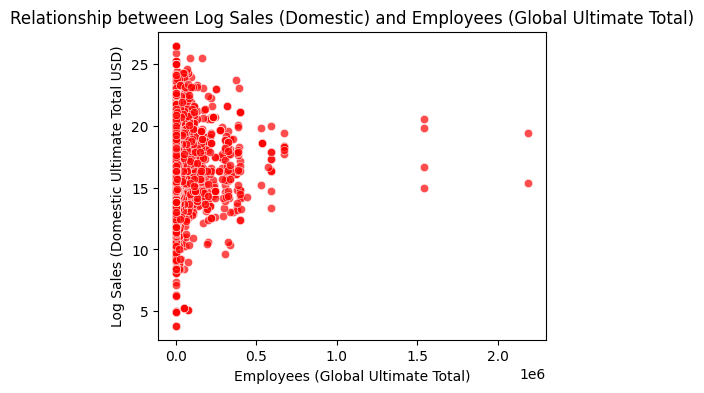

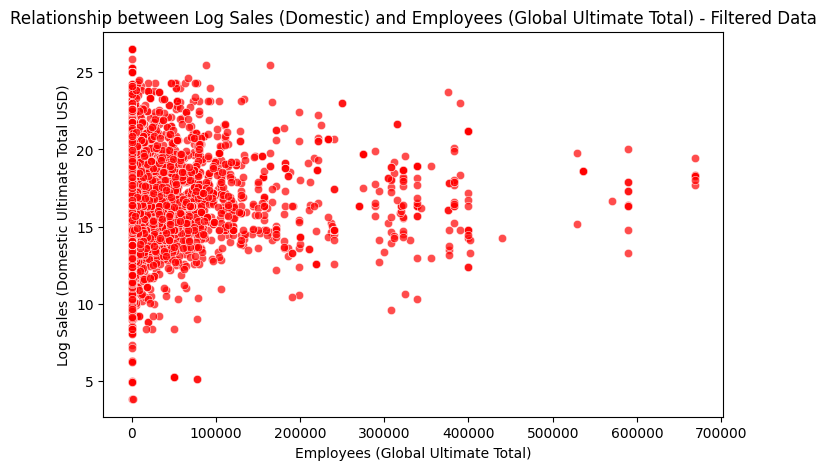

In [182]:
# Employees (Single Site)
plt.figure(figsize=(5, 4))
sns.scatterplot(x='Employees (Single Site)', y='Log Sales (Domestic Ultimate Total USD)', data=df3, color='coral', alpha=0.7)
plt.title('Relationship between Log Sales (Domestic) and Employees (Single Site)')
plt.ylabel('Log Sales (Domestic Ultimate Total USD)')
plt.xlabel('Employees (Single Site)')
plt.show()

# Since most of the data are clustered between 0 and 8000, we filter out outliers for better visualization.
df3_filtered = df3[df3['Employees (Single Site)'] <= 8000]

plt.figure(figsize=(8, 5))
sns.scatterplot(x='Employees (Single Site)', y='Log Sales (Domestic Ultimate Total USD)', data=df3_filtered, color='red', alpha=0.7)
plt.title('Relationship between Log Sales (Domestic) and Employees (Single Site) - Filtered Data')
plt.ylabel('Log Sales (Domestic Ultimate Total USD)')
plt.xlabel('Employees (Single Site)')
plt.show()

# Employees (Domestic Ultimate Total)
plt.figure(figsize=(5, 4))
sns.scatterplot(x='Employees (Domestic Ultimate Total)', y='Log Sales (Domestic Ultimate Total USD)', data=df3, color='blue', alpha=0.7)
plt.title('Relationship between Log Sales (Domestic) and Employees (Domestic Ultimate Total)')
plt.ylabel('Log Sales (Domestic Ultimate Total USD)')
plt.xlabel('Employees (Domestic Ultimate Total)')
plt.show()

# Since most of the data are clustered between 0 and 10000, we filter out outliers for better visualization.
df3_filtered = df3[df3['Employees (Domestic Ultimate Total)'] <= 10000]

plt.figure(figsize=(8, 5))
sns.scatterplot(x='Employees (Domestic Ultimate Total)', y='Log Sales (Domestic Ultimate Total USD)', data=df3_filtered, color='red', alpha=0.7)
plt.title('Relationship between Log Sales (Domestic) and Employees (Domestic Ultimate Total) - Filtered Data')
plt.ylabel('Log Sales (Domestic Ultimate Total USD)')
plt.xlabel('Employees (Domestic Ultimate Total)')
plt.show()

# Employees (Global Ultimate Total)
plt.figure(figsize=(5, 4))
sns.scatterplot(x='Employees (Global Ultimate Total)', y='Log Sales (Domestic Ultimate Total USD)', data=df3, color='red', alpha=0.7)
plt.title('Relationship between Log Sales (Domestic) and Employees (Global Ultimate Total)')
plt.ylabel('Log Sales (Domestic Ultimate Total USD)')
plt.xlabel('Employees (Global Ultimate Total)')
plt.show()

# Since most of the data are clustered between 0 and 1000000, we filter out outliers for better visualization.
df3_filtered = df3[df3['Employees (Global Ultimate Total)'] <= 1000000]

plt.figure(figsize=(8, 5))
sns.scatterplot(x='Employees (Global Ultimate Total)', y='Log Sales (Domestic Ultimate Total USD)', data=df3_filtered, color='red', alpha=0.7)
plt.title('Relationship between Log Sales (Domestic) and Employees (Global Ultimate Total) - Filtered Data')
plt.ylabel('Log Sales (Domestic Ultimate Total USD)')
plt.xlabel('Employees (Global Ultimate Total)')
plt.show()









There do not seem to be a clear relationship between employee numbers and domestic sales, which is also evidenced by the low correlation coefficients in the correlation matrix from section 5.2.1.

From the correlation matrix in section 5.2.1, the highest correlation value of 0.33 occured between Employees (Global Ultimate Total) and Log Sales (Global Ultimate Total USD). Therefore, we decided to plot a scatterplot to visualise this relationship.

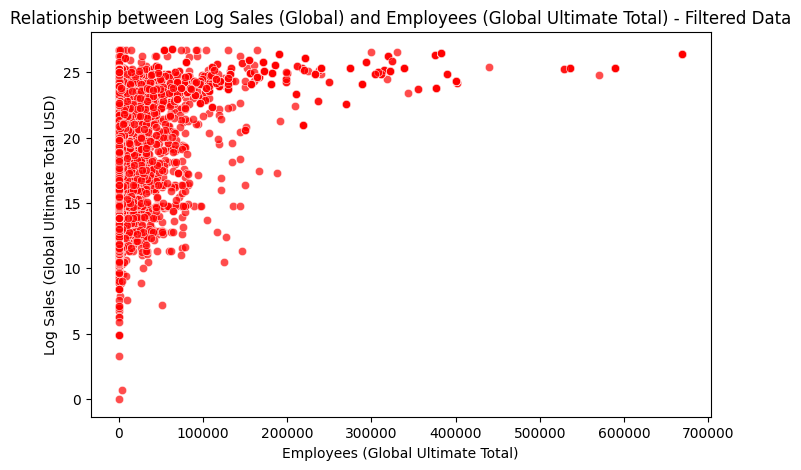

In [183]:
# Employees (Global Ultimate Total)
df3_filtered = df3[df3['Employees (Global Ultimate Total)'] <= 1000000]
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Employees (Global Ultimate Total)', y='Log Sales (Global Ultimate Total USD)', data=df3_filtered, color='red', alpha=0.7)
plt.title('Relationship between Log Sales (Global) and Employees (Global Ultimate Total) - Filtered Data')
plt.ylabel('Log Sales (Global Ultimate Total USD)')
plt.xlabel('Employees (Global Ultimate Total)')
plt.show()

From the scatterplot, it seems that generally, companies with more employees globally have larger global sales.

## 5.3 CATEGORICAL FEATURES ANALYSIS

### 5.3.1 ANOVA ANALYSIS OF CATEGORICAL VARIABLES

One-way ANOVA is employed to find the significance of categorical variables in predicting sales.

In [184]:
catvars = ['Entity Type', 'Ownership Type', 'Import/Export Status', 'Import/Export Status_Missing', 'Cluster', 'Is Domestic Ultimate', 'Is Global Ultimate']
for var in catvars:
    df3[var] = df3[var].astype('category')

    # Perform ANOVA for Domestic Sales
    anova_result = stats.f_oneway(*[df3[df3[var] == category]['Log Sales (Domestic Ultimate Total USD)']
                                for category in df3[var].cat.categories])

    print(f"{var}, Domestic Sales: ANOVA p-value: {anova_result.pvalue}")

    # Repeat for Global Sales
    anova_result = stats.f_oneway(*[df3[df3[var] == category]['Log Sales (Global Ultimate Total USD)']
                                for category in df3[var].cat.categories])

    print(f"{var}, Global Sales: ANOVA p-value: {anova_result.pvalue}")

Entity Type, Domestic Sales: ANOVA p-value: 2.3934548821649404e-297
Entity Type, Global Sales: ANOVA p-value: 0.0
Ownership Type, Domestic Sales: ANOVA p-value: 5.913714147810998e-84
Ownership Type, Global Sales: ANOVA p-value: 2.3186914259148446e-19
Import/Export Status, Domestic Sales: ANOVA p-value: 1.4325513721477228e-18
Import/Export Status, Global Sales: ANOVA p-value: 0.0012888673915650076
Import/Export Status_Missing, Domestic Sales: ANOVA p-value: 3.474309666742065e-164
Import/Export Status_Missing, Global Sales: ANOVA p-value: 1.467561941721543e-194
Cluster, Domestic Sales: ANOVA p-value: 0.006108082438358746
Cluster, Global Sales: ANOVA p-value: 0.021977581282677395
Is Domestic Ultimate, Domestic Sales: ANOVA p-value: 9.413311726926743e-204
Is Domestic Ultimate, Global Sales: ANOVA p-value: 1.787999532752018e-10
Is Global Ultimate, Domestic Sales: ANOVA p-value: 0.0
Is Global Ultimate, Global Sales: ANOVA p-value: 0.0


We observe that all the p values are very small (< 0.05). However, due to the non-normal distribution of sales, the p-value for ANOVA may not be fully representative of the significance of variables.

Still, from a practical standpoint, different entity/ownership type may confer distinct advantages or challenges that affect sales volume (independent companies may have comparatively less resources than subsidiaries for sales expansion). Similarly, import/export status affects the size of a company’s market, thus we opt to include these variables as features.

### 5.3.2 ANALYSIS OF IMPORT/EXPORT STATUS

We plot boxplots to see if there is a correlaton between domestic/global sales and whether the company is importing, exporting or both.

<ipython-input-185-0fc335f39e41>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df3.boxplot(column= ["Log Sales (Domestic Ultimate Total USD)", "Log Sales (Global Ultimate Total USD)"], by="Import/Export Status", ax=ax, showfliers = True)


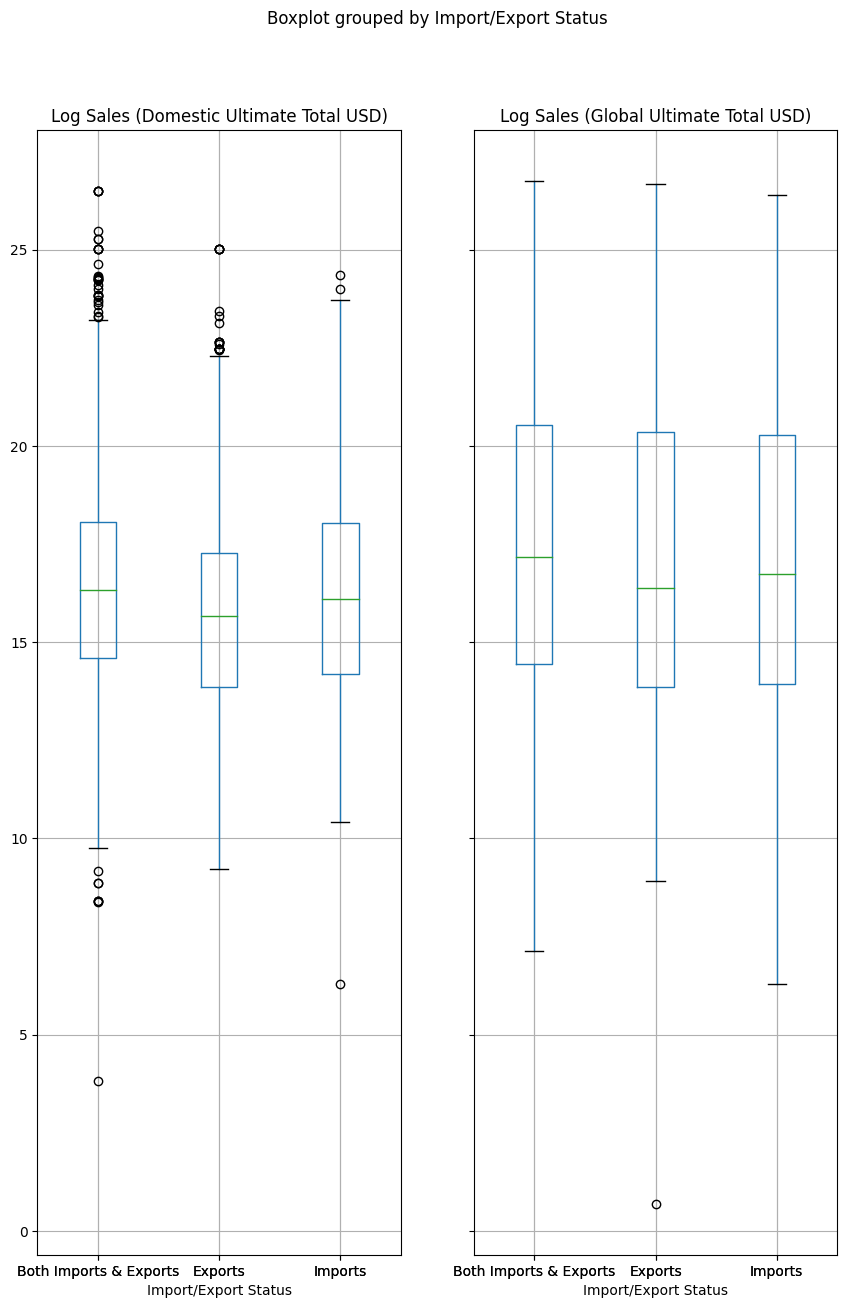

In [185]:
fig, ax = plt.subplots(figsize=(10, 15))
# Group by "Import/Export" and plot boxplots for each sales type
df3.boxplot(column= ["Log Sales (Domestic Ultimate Total USD)", "Log Sales (Global Ultimate Total USD)"], by="Import/Export Status", ax=ax, showfliers = True)
#ax.set_title("Sales by Import/Export Status")
ax.set_ylabel("Sales")
plt.show()

We see that generally, companies that import or do both imports and exports have slightly higher sales than those who export only.

# 6. FINAL DATA PROCESSING



## 6.1 DECIDING ON FINAL PREDICTORS

Given that Employees (Single Site) has a slight correlation with other feature variables (e.g., Employees (Domestic Ultimate Total) but low correlation with both sales variables, we opt to remove this variable from the dataset to avoid issues with multicollinearity. Employee (Single Site) was also incomplete, containing over 12000 null values that required KNN imputation that may not be representative of actual data.

We also drop Longitute and Latitude columns since they have been grouped into clusters.

Quantitative Variables: Longitude, Latitude, Employee (Single Site) will be dropped, all others retained

Categorical Variables: All retained

In [187]:
df4 = df3.drop(columns = ['LONGITUDE', 'LATITUDE', 'Employees (Single Site)'], axis = 1)
# Columns left after dropping
print(df4.shape)
df4.head(5)

(29059, 15)


,SIC Code,Year Found,Entity Type,Ownership Type,Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Is Domestic Ultimate,Is Global Ultimate,Import/Export Status_Missing,Log Sales (Domestic Ultimate Total USD),Log Sales (Global Ultimate Total USD),Cluster
0,7,2020,Subsidiary,Private,25.0,25.0,2.209224e+06,4.637871e+06,NaN,0.0,0.0,True,14.608152,15.349766,1
1,4,2015,Subsidiary,Private,100.0,100.0,7.093536e+09,7.093536e+09,NaN,0.0,0.0,True,22.682450,22.682450,1
2,6,1993,Subsidiary,Private,4.0,4.0,1.026308e+06,1.026308e+06,NaN,1.0,0.0,True,13.841478,13.841478,1
3,6,2006,Subsidiary,Private,100.0,100.0,7.339898e+10,7.339898e+10,NaN,0.0,0.0,True,25.019176,25.019176,1
4,6,2006,Parent,Private,4.0,4.0,4.322130e+05,4.322130e+05,Exports,1.0,1.0,False,12.976674,12.976674,1


## 6.2 ONE-HOT ENCODING

In [188]:
# one-hot encoding for categorical variables with (N-1) dummy variables
df4 = pd.get_dummies(df4, columns=['SIC Code','Entity Type', 'Ownership Type', 'Import/Export Status', 'Cluster'], drop_first = True)
df4.shape
df4.head(10)

# change values from categories to integer
df4['Is Domestic Ultimate'] = df4['Is Domestic Ultimate'].cat.codes
df4['Is Global Ultimate'] = df4['Is Global Ultimate'].cat.codes
df4['Import/Export Status_Missing'] = df4['Import/Export Status_Missing'].cat.codes




# 7. MODEL TRAINING AND EVALUATION

We employed the following methodology for model training and selection:

1) Split the data into training and testing sets with an 80:20 train-test split.

2) Perform 8-fold cross-validation on the training dataset to compare across different models.

3) Evaluate model effectiveness using R-squared and MSE for variance explanation and AIC for model complexity and fit.

After testing up to 10 regression models, including Multiple Linear Regression, L1 and L2 Regularization, and various ensemble methods, we have shortlisted four models based on the highest R-squared and lowest AIC values: Random Forest Regression, Gradient Boosting Regression, XGBoost (XGB) Regression, and LightGBM (LGBM) Regression. The metrics for these models are shown below.

## 7.1 MODEL SELECTION

In [190]:
lgbm_regressor = LGBMRegressor()

models = [
    RandomForestRegressor(n_estimators=50, random_state=42),
    GradientBoostingRegressor(),
    XGBRegressor(objective='reg:squarederror'),
    lgbm_regressor,
]

## 7.2 CROSS VALIDATION

In [191]:
df_train = df4.drop(columns = ['Sales (Domestic Ultimate Total USD)',
                                    'Sales (Global Ultimate Total USD)',
                                    'Log Sales (Domestic Ultimate Total USD)',
                                    'Log Sales (Global Ultimate Total USD)'], axis = 1)

# Initially target_columns included both domestic and global sales but has currently been changed to global for the sake of our tests
# target_columns = ['Log Sales (Domestic Ultimate Total USD)', 'Log Sales (Global Ultimate Total USD)' ]
target_columns = ['Log Sales (Domestic Ultimate Total USD)']

X = df_train
kf = KFold(n_splits=8, shuffle=True, random_state=42)



## 7.3 MODEL EVALUATION METRICS

In [192]:
def calculate_aic(y_true, y_pred, n_params):
    n = len(y_true)
    mse = np.mean((y_true - y_pred) ** 2)
    aic = n * np.log(mse) + 2 * n_params
    return -aic  # Negative sign for cross_val_score maximization

# Custom scorer for AIC
aic_scorer = make_scorer(calculate_aic, greater_is_better=False, n_params=1)


for target_column in target_columns:
    y = df4[target_column]

    for model in models:
            # Use cross_val_score to perform cross-validation and get performance metrics
            scores_mse = -cross_val_score(model, df_train, y, scoring='neg_mean_squared_error', cv=kf)
            scores_r2 = cross_val_score(model, df_train, y, scoring='r2', cv=kf)
            scores_aic = cross_val_score(model, df_train, y, scoring=aic_scorer, cv=kf)

            # Calculate average performance across all folds
            avg_mse = np.mean(scores_mse)
            avg_r2 = np.mean(scores_r2)
            avg_aic = np.mean(scores_aic)

            print(f"{model.__class__.__name__} - {target_column}")
            print(f"Average Mean Squared Error: {avg_mse}")
            print(f"Average R-squared: {avg_r2}")
            print(f"Average AIC: {avg_aic}")
            print()


RandomForestRegressor - Log Sales (Domestic Ultimate Total USD)
Average Mean Squared Error: 2.516821500061623
Average R-squared: 0.6099179355051514
Average AIC: 3347.880326027217

GradientBoostingRegressor - Log Sales (Domestic Ultimate Total USD)
Average Mean Squared Error: 2.571904296239224
Average R-squared: 0.6014041482852768
Average AIC: 3428.670193655146

XGBRegressor - Log Sales (Domestic Ultimate Total USD)
Average Mean Squared Error: 2.374926539505229
Average R-squared: 0.6319395978968368
Average AIC: 3138.804310840165

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 25426, number of used features: 24
[LightGBM] [Info] Start training from score 15.565467
[LightGBM] [Warning] Found whitespace in fe

We selected LGBM Regression as our preferred model, with R-squared = 0.636, MSE = 2.348 and AIC = 3096. Given the complexity of the dataset due to the number of parameters, the precision achieved by LGBM Regression is relatively promising. However, it is worth noting that due to a substantial amount of null values in the dataset that required imputations.  Such imputations, while necessary, can introduce biases or distortions, potentially impacting the model's ability to accurately predict new, unseen data, which may affect its generalisability.

# 8. SAVING AND TESTING THE MODEL

In [194]:
import joblib

# Save the base model to an HDF5 file
lgbm_regressor.fit(df_train, df4['Log Sales (Domestic Ultimate Total USD)'])
joblib.dump(lgbm_regressor, 'team58_model.h5')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 29059, number of used features: 24
[LightGBM] [Info] Start training from score 15.571010


['team58_model.h5']

# 9. PREDICTING NEW VALUES

In [195]:
# Helper functions for clean_data

def order_sic_data(df):
  #Extract first digit of SIC Code
  df['SIC Code'] = df['SIC Code'].astype(int)
  df['SIC Code'] //= 1000
  df['SIC Code'] = df['SIC Code'].astype(str)

  # Set a threshold for low-frequency SIC Codes
  threshold = 0.1 * len(df)

  # Identify SIC Codes with frequency below the threshold
  sic_code_frequency = df['SIC Code'].value_counts()
  low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index.tolist()

  # Replace these low-frequency SIC Codes with a common label "Others"
  df['SIC Code'] = df['SIC Code'].replace(low_frequency_sic_codes, 'Others')
  return df

def create_cluster(df):
  df = df.dropna(subset=["LATITUDE", "LONGITUDE"])
  # Choosing the number of clusters (k)
  X = df[['LATITUDE', 'LONGITUDE']]
  kmeans = KMeans(n_clusters=4, n_init = 'auto')
  kmeans.fit(X)

  # Getting cluster assignments
  df['Cluster'] = kmeans.labels_
  return df

def fill_missing_values(df):
  imputer = KNNImputer(n_neighbors=5)
  # Select columns for imputation
  columns_to_impute = ['Employees (Single Site)', 'Year Found', 'Employees (Domestic Ultimate Total)','Employees (Global Ultimate Total)'   ]
  # Perform imputation
  df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
  return df

def create_dummies(df):
  df['Import/Export Status_Missing'] = df['Import/Export Status'].isna()

  # 1 hot encoding
  df = pd.get_dummies(df, columns=['SIC Code', 'Entity Type', 'Ownership Type', 'Import/Export Status', 'Cluster'], drop_first = True)

  # change values from categories to integer
  df['Is Domestic Ultimate'] = df['Is Domestic Ultimate'].astype('int')
  df['Is Global Ultimate'] = df['Is Global Ultimate'].astype('int')
  df['Import/Export Status_Missing'] = df['Import/Export Status_Missing'].astype('int')
  return df

def fill_missing_columns(df):
  columns_to_fill = [
          'Year Found',
          'Employees (Domestic Ultimate Total)',
          'Employees (Global Ultimate Total)',
          'Is Domestic Ultimate',
          'Is Global Ultimate',
          'Import/Export Status_Missing',
          'SIC Code_4',
          'SIC Code_5',
          'SIC Code_6',
          'SIC Code_7',
          'SIC Code_8',
          'SIC Code_Others',
          'Entity Type_Independent',
          'Entity Type_Parent',
          'Entity Type_Subsidiary',
          'Ownership Type_Nonprofit',
          'Ownership Type_Partnership',
          'Ownership Type_Private',
          'Ownership Type_Public',
          'Ownership Type_Public Sector',
          'Import/Export Status_Exports',
          'Import/Export Status_Imports',
          'Cluster_1',
          'Cluster_2',
          'Cluster_3'
      ]
  # Add missing columns with 0 value if they don't exist in the DataFrame
  for column in columns_to_fill:
      if column not in df.columns:
          df[column] = 0

  return df

In [196]:
def clean_data(hidden_data: pd.DataFrame) -> pd.DataFrame:
  full_data = fill_missing_values(hidden_data)
  ordered_sic_data = order_sic_data(full_data)
  clustered_data = create_cluster(ordered_sic_data)
  dropped_data = clustered_data.drop(columns=[col for col in ["Industry", "8-Digit SIC Code", "8-Digit SIC Description", "Company Status (Active/Inactive)", "AccountID", "Square Footage", "Company", "Company Description", "Domestic Ultimate Company", "Fiscal Year End", "Parent Company", "Parent Country", "Global Ultimate Company", "Global Ultimate Country", "LONGITUDE", "LATITUDE", "Employees (Single Site)"] if col in clustered_data.columns], errors='ignore')
  cleaned_data = create_dummies(dropped_data)
  complete_data = fill_missing_columns(cleaned_data)
  return complete_data


In [197]:
def load_model():
  loaded_model = joblib.load('./team58_model.h5')
  return loaded_model

loaded_model = load_model()

In [198]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    cleaned_data = clean_data(hidden_data)

    result = loaded_model.predict(cleaned_data)
    actual_result = np.exp(result)
    return actual_result

In [199]:
test_df = pd.read_csv('/content/drive/MyDrive/catA_train.csv', nrows=200)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)', 'Sales (Global Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[3.19136211e+06 2.71568015e+08 6.52143651e+05 2.74822934e+08
 9.42047036e+05 8.95817580e+05 2.13436529e+07 8.95041840e+05
 9.92093288e+05 6.06149449e+07 2.42059893e+07 1.98018119e+06
 5.04869803e+05 1.02557666e+06 4.54612034e+06 3.53213679e+06
 4.43573354e+07 6.77332185e+05 4.67094776e+05 1.02590330e+08
 3.15503541e+06 9.20747904e+05 7.24048539e+06 5.45099318e+07
 3.55802886e+05 8.62866869e+05 8.18289078e+05 3.22637494e+08
 8.37169294e+05 5.83381693e+05 1.51136314e+06 7.97100063e+05
 3.46725424e+05 1.57276757e+06 5.04869803e+05 9.82669776e+05
 1.37497649e+07 2.75325772e+06 1.87126284e+06 6.96328847e+05
 9.05171602e+05 3.40896682e+06 1.98235283e+08 2.27323148e+07
 1.65277666e+06 5.09573320e+08 3.97169739e+05 5.79911251e+05
 4.40272964e+05 3.43472787e+08 5.39850752e+05 9.47838256e+06
 1.49806780e+07 1.01143493e+07 1.50623410e+06 2.38658038e+07
 6.63139791e+07 3.55802886e+05 9.82669776e+05 7.97204956e+07
 4.60292483e+06 1.90668400e+07 1.03928165e+08 9.63916060e+05
 1.94730107e+08 1.324675